# Explore Physionet CTG Outcome Metadata Apgar 1

see: https://physionet.org/physiobank/database/ctu-uhb-ctgdb/

Includes:
- Plots of various outcome metrics vs apgar 1
- Regression models to predict apgar1 from other outcome metrics

In [1]:
import config_local
from config_common import *

In [2]:
import wfdb
import os
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
from sklearn import svm
from sklearn.decomposition import PCA
import math
import collections

In [3]:
from ctg_utils import get_all_recno, parse_meta_comments

In [4]:
import random

# Config

# Code

In [5]:
def jitter(x, w=2):
    return x + (random.random()-0.5)/w

In [6]:
def display_metric_vs_apgar(metric, apgar, title='', xlabel='', ylabel='', 
                            limits=None, thresh=None):
    plt.figure(figsize=(5,5))
    if title:
        plt.title(title)
    plt.scatter(metric, [jitter(x) for x in apgar], s=3)
    if thresh:
        plt.plot([thresh, thresh], [0, 10], 'r--')
    plt.ylim(0, 10)
    if limits:
        plt.plot(limits, [7, 7], 'r--')
        plt.xlim(*limits)
    if ylabel:
        plt.ylabel(ylabel)
    if apgar:
        plt.xlabel(xlabel)
    plt.show()

In [7]:
def display_predictions(actual, pred, title=None, xlabel='Apgar 5'):
    all_error = [abs(val-pred[i])  for i, val in enumerate(actual)]
    print('Error -- mean: {:0.2f}   std: {:0.2f}'.format(np.mean(all_error), np.std(all_error)))
    plt.figure(figsize=(5,5))
    if title:
        plt.title(title)
    plt.scatter([jitter(x) for x in actual], [x for x in pred], s=3)
    plt.ylim(0, 10)
    plt.xlim(0, 10)
    plt.plot([0,10], [0, 10], 'g--', alpha=0.25)
    plt.plot([0,9.5], [0.5, 10], 'r--', alpha=0.25)
    plt.plot([0.5,10], [0, 9.5], 'r--', alpha=0.25)

    plt.plot([7,7], [0, 10], 'r--', alpha=0.25)
    plt.plot([0, 10], [7,7], 'r--', alpha=0.25)
    plt.ylabel('Predicted {}'.format(xlabel))
    plt.xlabel(xlabel)
    plt.show()

# Gather All Recording Metadata

In [8]:
all_meta = {}
all_error = []
for recno in sorted(get_all_recno(media_recordings_dir_full)):
    recno_full = os.path.join(media_recordings_dir_full, recno)
    #print('Record: {}'.format(recno))
    try:
        all_sig, meta = wfdb.io.rdsamp(recno_full)
        meta['comments'] = parse_meta_comments(meta['comments'])
        all_meta[recno] = meta['comments']
    except Exception as e:
        print('    Error: {}'.format(e))
        all_error.append(recno)

### Filter nan values

In [9]:
for recno in sorted(all_meta.keys()):
    entry = all_meta[recno]['Outcome']
    if math.isnan(entry['BDecf']):
        print('{}: Recording contains NaN'.format(recno))
        del all_meta[recno]

1044: Recording contains NaN
1070: Recording contains NaN
1211: Recording contains NaN
1215: Recording contains NaN
1356: Recording contains NaN
1373: Recording contains NaN
1383: Recording contains NaN
1419: Recording contains NaN
2006: Recording contains NaN
2034: Recording contains NaN
2046: Recording contains NaN


# Outcomes

In [10]:
for recno in sorted(all_meta.keys()):
    # recno = '1001'
    entry = all_meta[recno]['Outcome']
    print('{:4}: pH:{:5.2f}   BDecf: {:5.2f}    pCO2: {:5.2f}    BE: {:6.2f}    Apgar1: {:2}    Apgar5: {:2}'.format(
        recno, entry['pH'], entry['BDecf'], entry['pCO2'], entry['BE'], entry['Apgar1'], entry['Apgar5']))

1001: pH: 7.14   BDecf:  8.14    pCO2:  7.70    BE: -10.50    Apgar1:  6    Apgar5:  8
1002: pH: 7.00   BDecf:  7.92    pCO2: 12.00    BE: -12.00    Apgar1:  8    Apgar5:  8
1003: pH: 7.20   BDecf:  3.03    pCO2:  8.30    BE:  -5.60    Apgar1:  7    Apgar5:  9
1004: pH: 7.30   BDecf:  5.19    pCO2:  5.50    BE:  -6.40    Apgar1:  8    Apgar5:  9
1005: pH: 7.30   BDecf:  4.52    pCO2:  5.70    BE:  -5.80    Apgar1:  9    Apgar5: 10
1006: pH: 7.23   BDecf:  1.29    pCO2:  8.20    BE:  -3.80    Apgar1:  8    Apgar5:  9
1007: pH: 7.16   BDecf:  4.35    pCO2:  8.80    BE:  -6.80    Apgar1:  9    Apgar5: 10
1008: pH: 7.36   BDecf:  3.88    pCO2:  4.90    BE:  -4.60    Apgar1:  8    Apgar5:  9
1009: pH: 7.18   BDecf:  7.60    pCO2:  7.00    BE:  -9.60    Apgar1:  8    Apgar5:  9
1010: pH: 7.35   BDecf:  5.20    pCO2:  4.70    BE:  -5.90    Apgar1:  8    Apgar5:  9
1011: pH: 7.37   BDecf:  1.73    pCO2:  5.30    BE:  -2.60    Apgar1:  8    Apgar5:  9
1012: pH: 7.36   BDecf:  0.82    pCO2:  5.7

In [11]:
all_pH = [entry['Outcome']['pH'] for entry in all_meta.values()]
all_BDecf = [entry['Outcome']['BDecf'] for entry in all_meta.values()]
all_pCO2 = [entry['Outcome']['pCO2'] for entry in all_meta.values()]
all_BE = [entry['Outcome']['BE'] for entry in all_meta.values()]
all_Apgar1 = [entry['Outcome']['Apgar1'] for entry in all_meta.values()]
all_Apgar5 = [entry['Outcome']['Apgar5'] for entry in all_meta.values()]

all_pH_lin = [10**(entry['Outcome']['pH']-7) for entry in all_meta.values()]

## Show pH vs Apgar1

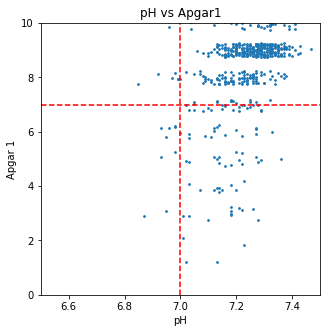

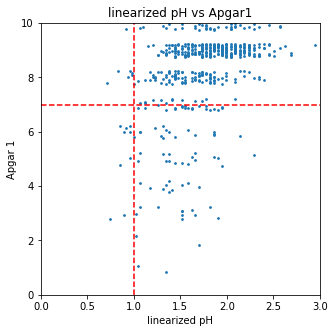

In [12]:
display_metric_vs_apgar(all_pH, all_Apgar1, limits=[6.5, 7.5],thresh=7,
                        title='pH vs Apgar1', xlabel='pH', ylabel='Apgar 1')   

display_metric_vs_apgar(all_pH_lin, all_Apgar1, limits=[0,3], thresh=1,
                        title='linearized pH vs Apgar1', xlabel='linearized pH', ylabel='Apgar 1')  

## Show BDecf vs Apgar1

-3.4 26.11


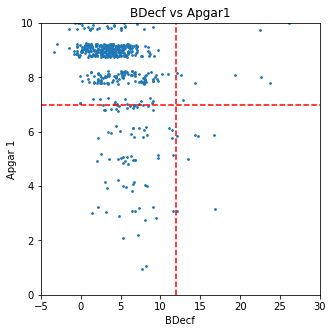

In [13]:
print(np.min(all_BDecf), np.max(all_BDecf))

display_metric_vs_apgar(all_BDecf, all_Apgar1, limits=[-5, 30], thresh=12,
                        title='BDecf vs Apgar1', xlabel='BDecf', ylabel='Apgar 1') 

### Drilldown:  BDecf vs Apgar1 for pH normal and abnormal pH

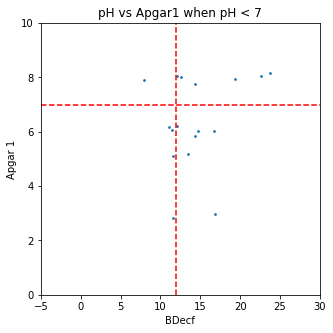

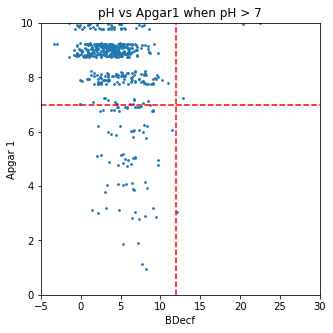

In [14]:
idx_subset = [i for i, x in enumerate(all_pH) if x <= 7]
display_metric_vs_apgar([all_BDecf[i] for i in idx_subset], [all_Apgar1[i] for i in idx_subset], 
                        limits=[-5, 30], thresh=12,
                        title='pH vs Apgar1 when pH < 7', xlabel='BDecf', ylabel='Apgar 1') 

idx_subset = [i for i, x in enumerate(all_pH) if x > 7]
display_metric_vs_apgar([all_BDecf[i] for i in idx_subset], [all_Apgar1[i] for i in idx_subset], 
                        limits=[-5, 30], thresh=12,
                        title='pH vs Apgar1 when pH > 7', xlabel='BDecf', ylabel='Apgar 1') 

## Show BE vs Apgar1

-26.8 -0.2


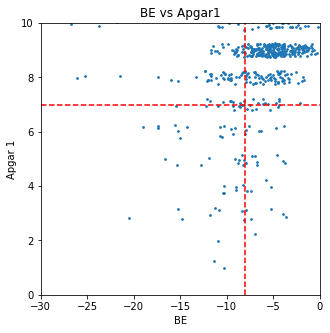

In [15]:
print(np.min(all_BE), np.max(all_BE))
display_metric_vs_apgar(all_BE, all_Apgar1, limits=[-30, 0], thresh=-8,
                        title='BE vs Apgar1', xlabel='BE', ylabel='Apgar 1') 

### Drilldown:  BE vs Apgar1 for pH normal and abnormal pH

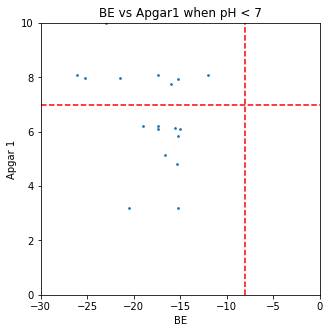

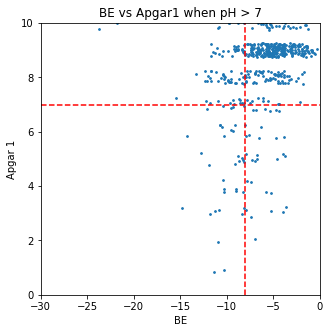

In [16]:
idx_subset = [i for i, x in enumerate(all_pH) if x <= 7]

display_metric_vs_apgar([all_BE[i] for i in idx_subset], [all_Apgar1[i] for i in idx_subset], 
                        limits=[-30, 0], thresh=-8,
                        title='BE vs Apgar1 when pH < 7', xlabel='BE', ylabel='Apgar 1') 

idx_subset = [i for i, x in enumerate(all_pH) if x > 7]
display_metric_vs_apgar([all_BE[i] for i in idx_subset], [all_Apgar1[i] for i in idx_subset], 
                        limits=[-30, 0], thresh=-8,
                        title='BE vs Apgar1 when pH > 7', xlabel='BE', ylabel='Apgar 1') 


## PCA

In [17]:
all_features = list(zip(all_Apgar1, all_BE, all_pH_lin, all_pH))

In [18]:
# Determine feature count by APGAR
counts = collections.defaultdict(int)
feature_by_apgar = collections.defaultdict(list)
for i, x in enumerate(all_Apgar1):
    counts[x] += 1
    feature_by_apgar[x].append(all_features[i])

for k in sorted(counts.keys()):
    print(k, counts[k])

# equalize feature set without replace

max_entries = 14
train_features = []
train_labels = []

for k, v in feature_by_apgar.items():
    if len(v) <= max_entries:
        train_features += v
        train_labels += [k] * len(v)
    else:
        train_labels += [k] * max_entries
        for i in np.random.choice(np.arange(len(v)), size=max_entries, replace=False):
            train_features.append(v[i])
        
train_features = np.vstack(train_features)

1 2
2 2
3 13
4 10
5 18
6 21
7 34
8 102
9 274
10 65


Error -- mean: 1.91   std: 1.28


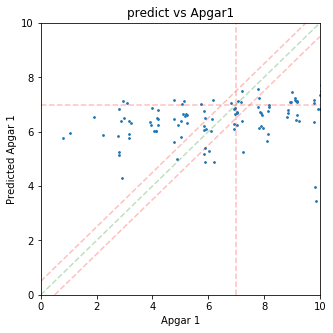

In [19]:
n_components = 1

pca = PCA(n_components=n_components)
pca.fit(train_features)
predict = pca.inverse_transform((pca.transform(train_features)))

display_predictions(train_labels, [x[0] for x in predict], title='predict vs Apgar1', xlabel='Apgar 1')

In [20]:
pca.components_

array([[-0.17002721, -0.98285472, -0.06826169, -0.02068077]])

In [21]:
pca.explained_variance_ratio_ 

array([0.77779178])

In [22]:
print('  all_Apgar1,  all_BE,     all_pH_lin  all_pH')
print(pca.get_covariance())

  all_Apgar1,  all_BE,     all_pH_lin  all_pH
[[ 2.36527923  2.94616761  0.20461864  0.06199188]
 [ 2.94616761 18.88614959  1.182813    0.35834858]
 [ 0.20461864  1.182813    1.93776148  0.0248882 ]
 [ 0.06199188  0.35834858  0.0248882   1.86315239]]


### Try again ignoring pH (log version)

In [23]:
# strip pH from training set
train_features = [x[:-1] for x in train_features]

Error -- mean: 1.91   std: 1.28


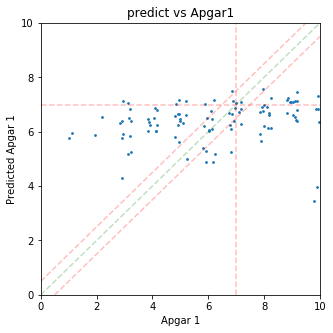

In [24]:
n_components = 1

pca = PCA(n_components=n_components)
pca.fit(train_features)
predict = pca.inverse_transform((pca.transform(train_features)))

display_predictions(train_labels, [x[0] for x in predict], title='predict vs Apgar1', xlabel='Apgar 1')

In [25]:
pca.components_

array([[-0.17001332, -0.98307448, -0.06826441]])

In [26]:
pca.explained_variance_ratio_ 

array([0.77781201])

In [27]:
print('  all_Apgar1,  all_BE,     all_pH_lin')
print(pca.get_covariance())

  all_Apgar1,  all_BE,     all_pH_lin
[[ 3.26447128  2.79037673  0.19376297]
 [ 2.79037673 18.91680422  1.12040301]
 [ 0.19376297  1.12040301  2.85970282]]


# Modeling:  Extimate Apgar1 using Outcome Metrics

In [28]:
all_features = list(zip(all_pH, all_BDecf, all_pCO2, all_BE, all_pH_lin))

## SVM Regression #1
Without Replacement (limit number of features by apgar)

In [29]:
# Determine feature count by APGAR
counts = collections.defaultdict(int)
feature_by_apgar1 = collections.defaultdict(list)
for i, x in enumerate(all_Apgar1):
    counts[x] += 1
    feature_by_apgar1[x].append(all_features[i])

for k in sorted(counts.keys()):
    print(k, counts[k])

1 2
2 2
3 13
4 10
5 18
6 21
7 34
8 102
9 274
10 65


In [30]:
max_entries = 14
train_features = []
train_labels = []

for k, v in feature_by_apgar1.items():
    print(k, len(v))
    if len(v) <= max_entries:
        train_features += v
        train_labels += [k] * len(v)
    else:
        train_labels += [k] * max_entries
        for i in np.random.choice(np.arange(len(v)), size=max_entries, replace=False):
            train_features.append(v[i])
        
train_features = np.vstack(train_features)
train_features.shape, len(train_labels)

6 21
8 102
7 34
9 274
5 18
10 65
4 10
1 2
3 13
2 2


((111, 5), 111)

In [31]:
clf = svm.LinearSVR(max_iter=100000)
clf.fit(train_features, train_labels) 

pred_train = clf.predict(train_features) 
pred_test = clf.predict(all_features) 

Error -- mean: 1.80   std: 1.23


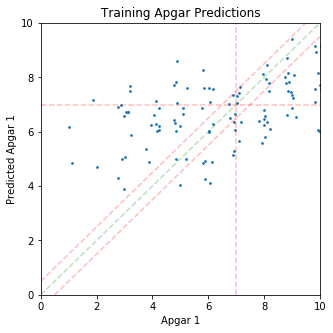

Error -- mean: 1.52   std: 0.96


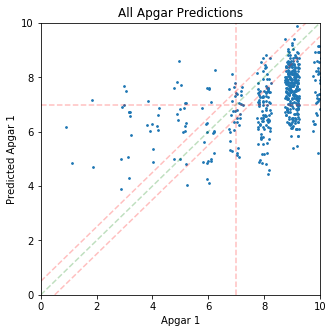

In [32]:
display_predictions(train_labels, pred_train, title='Training Apgar Predictions', xlabel='Apgar 1')
display_predictions(all_Apgar1, pred_test, title='All Apgar Predictions', xlabel='Apgar 1')

## SVM Regression #2
With Replacement (feature set for sames features for each apgar score)

In [33]:
# Trtaining Set Using Replacement

max_entries = 50
train_features = []
train_labels = []

for k, v in feature_by_apgar1.items():
    train_labels += [k] * max_entries
    for i in np.random.choice(np.arange(len(v)), size=max_entries, replace=True):
        train_features.append(v[i])
        
train_features = np.vstack(train_features)
train_features.shape, len(train_labels)

((500, 5), 500)

In [34]:
#clf = svm.LinearSVR(max_iter=100000)
clf = svm.SVR(max_iter=100000, gamma='scale')
clf.fit(train_features, train_labels) 

pred_train = clf.predict(train_features) 

pred_test = clf.predict(all_features) 

Error -- mean: 1.92   std: 1.47


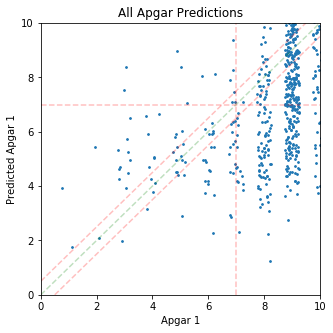

In [35]:
display_predictions(all_Apgar1, pred_test, title='All Apgar Predictions', xlabel='Apgar 1')